In [1]:
import os
import csv 
import json
from collections import defaultdict
from Bio import Seq
from itertools import product
from Bio.SeqUtils import MeltingTemp as mt
import gzip
import os
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter, FileType
import sys
import csv
from Bio import SeqIO
import pandas as pd
#import itables.interactive
from itables import show
import melting
import logging

<IPython.core.display.Javascript object>

In [3]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# displays logos inline within the notebook;
# remove if using a python interpreter instead
%matplotlib inline

# logomaker import
import logomaker

In [5]:
def get_tms(seqs, fct=mt.Tm_Wallace):
    # Tm_GC
    # Tm_Wallace
    return [fct(Seq.Seq(seq))  for seq in seqs]

def get_tms_from_melting(seqs):
    return [melting.temp(seq) for seq in seqs]

def get_degenerate_consensus_seq(seqs):
    """return an ambiguous DNA seq from a list of possible sequences """
    ambig_to_unambig = Seq.IUPAC.IUPACData.ambiguous_dna_values
    unambig_to_ambig = {tuple(sorted(unambigs)):ambig for ambig, unambigs in ambig_to_unambig.items() }
    
    positions = [defaultdict(int) for _ in range(len(seqs[0]))]
    for s in seqs:
        for l, position in zip(s,positions):
            position[l] += 1
    positions_tuple = [ tuple(sorted(''.join(po.keys()))) for po in positions]
    degenerate_seq = ''.join([unambig_to_ambig[t] for t in positions_tuple])
    return degenerate_seq


def extend_ambiguous_dna(deg_seq):
    """return list of all possible sequences given an ambiguous DNA input"""
    d = Seq.IUPAC.IUPACData.ambiguous_dna_values
    r = []
    for i in product(*[d[j] for j in deg_seq]):
        r.append("".join(i))
    return r


def get_tm_range(seqs, fct=get_tms):
    # https://biopython.org/DIST/docs/api/Bio.SeqUtils.MeltingTemp-module.html
    tm_list = fct(seqs)
    return round(min(tm_list),2), round(max(tm_list), 2)

def get_species_prct_from_ecotax(file):
    """Load a tsv file into a list of dictionnary"""
    main_dict = {}
    with open(file) as fl:
        
        for l in fl: 
            l_splitted = [e.strip() for e in l.split('\t')]
            if l_splitted[0] == 'species':
                return float(l_splitted[-1]) 
                
def tsv_to_dict_of_dicts(file, key_field):
    """
    Take a tsv with header and parse into dict of dict
    Uses
    * the specified field as key
    * the line turned into a dict as value .
    """
    dict_of_list_of_dict = defaultdict(list)
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        for l in reader:
            dict_of_list_of_dict[l[key_field]].append(l)
        return dict(dict_of_list_of_dict)
    


def get_best_couples_by_taxcov(region_dir):
    couple_sp_prct = {}
    
    primer_couples = os.listdir(region_dir) 
    primers_couple_dirs = [os.path.join(region_dir, couple)  for couple in primer_couples]
   
    
    for couple in primer_couples:
        couple_dir = os.path.join(region_dir, couple)
        ecotax_files = [f for f in os.listdir(couple_dir) if f.startswith('refseqRepRef') and f.endswith('_l500_L8000_e0.ecotaxstat')]
        if len(ecotax_files) > 1: 
            print('MORE THAN ONE ECOTAX')
            print(ecotax_files) 
        
        
        ecotax_file_name = ecotax_files[0] 
        ecotax_file = os.path.join(region_dir, couple, ecotax_file_name)
        species_prct = get_species_prct_from_ecotax(ecotax_file)
        
        couple_sp_prct[couple_dir] = species_prct
        sorted_couples = sorted(couple_sp_prct.items(), key=lambda kv: kv[1], reverse=True)
    return sorted_couples

def tsv_to_list_of_dict(file):
    """Load a tsv file into a list of dictionnary"""
    with open(file) as csvfile:
        reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), delimiter='\t')
        return list(reader)
    

def create_sarray_command(couple_dir):

    info_file = [f for f in os.listdir(couple_dir) if f.endswith('.json')][0]
    dict_info = decoder(os.path.join(couple_dir, info_file))
    #print(dict_info)
    primer1 = dict_info["forward_primer"]["seq"]
    p1_name = dict_info["forward_primer"]["primer_id"]
    primer2 = dict_info["reverse_primer"]["seq"]
    p2_name = dict_info["reverse_primer"]["primer_id"]
    pre_command = 'module load system/Anaconda3-5.2.0;source /usr/local/bioinfo/src/Anaconda/Anaconda3-5.2.0/etc/profile.d/conda.sh;conda activate check_primer_dimers;'

    command = 'python check_primer_dimers.py' + \
    f' -p {primer1} -P {primer2}' + \
    f' --primer_name1 {p1_name} --primer_name2 {p2_name}' + \
    f' -o {couple_dir} -e primer_prospector/dna_DM.par'

    print(pre_command + command)    

def decoder(filename):
    """Load a json file and return the corresponding structure."""
    with open(filename, 'r', encoding='utf8') as file:
        return json.load(file)

def list_of_dict_to_tsv(list_of_dict, output_file, mode='w', writeheader=True):
    """Encode a list of dictionnary into a tsv file

    The mode of writing can be specified.
    By default the mode is set to "w"

    """
    if len(list_of_dict) == 0:
        raise ValueError('The given list is empty: we cant write it in a file')

    with open(output_file, mode, newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=list(list_of_dict[0].keys()), delimiter='\t')
        if mode == 'w' and writeheader == True:
            writer.writeheader()
        for dict_info in list_of_dict:
            writer.writerow(dict_info)
def get_primer_used(ecopcrfile):
    fprimers_to_amplicons = defaultdict(list)
    rprimers_to_amplicons = defaultdict(list)
    
    fprimers_used = []
    rprimers_used = []
    i = 0
    with open(ecopcrfile, encoding="utf8", errors='ignore') as fl:
        for l in fl:
            if l.startswith('#'):
                continue
            i += 1
            
            splitted_l = [e.strip() for e in l.split(' | ')]
            f_primer_used = splitted_l[13]
            r_primer_used = splitted_l[16]
            seq_taxid = splitted_l[1]
            
            amplicon_id = f'amplicon_{i}'
            
            fprimers_to_amplicons[f_primer_used].append(amplicon_id)
            fprimers_used.append(f_primer_used)
            
            rprimers_to_amplicons[r_primer_used].append(amplicon_id)
            rprimers_used.append(r_primer_used)
            
    return fprimers_used, rprimers_used, fprimers_to_amplicons, rprimers_to_amplicons

def get_binding_results(binding_result_fl):
    binding_results = tsv_to_list_of_dict(binding_result_fl)
    fprimer_binds = []
    rprimer_binds = []

    for bind in binding_results: 
        primer1_bind, primer2_bind = bind['sequence_tested'].split('----------')
        if bind['primer1_version'][0] == 'f':
            fprimer_binds.append(primer1_bind)
        else:
            rprimer_binds.append(primer1_bind)
            
        if bind['primer2_version'][0] == 'f':
            fprimer_binds.append(primer2_bind)
        else:
            rprimer_binds.append(primer2_bind)
            
    return fprimer_binds, rprimer_binds


def get_info_couple_primers(couple_dir):
    info_file = [f for f in os.listdir(couple_dir) if f.endswith('.json')][0]
    json_info = decoder(os.path.join(couple_dir, info_file))
    fprimer = json_info["forward_primer"]["seq"]
    fp_name = json_info["forward_primer"]["primer_id"]
    rprimer = json_info["reverse_primer"]["seq"]
    rp_name = json_info["reverse_primer"]["primer_id"]
    
    ecotaxstat_name = f'refseqRepRef_{fp_name}-{rp_name}_l500_L8000_e0.ecotaxstat'
    ecotaxstat_file = os.path.join(couple_dir, ecotaxstat_name)
    json_info['ecotaxstat_file'] = ecotaxstat_file 
    
    ecopcr_name = f'refseqRepRef_{fp_name}-{rp_name}_l500_L8000_e0.ecopcr'

    ecopcr_file = os.path.join(couple_dir, ecopcr_name)
    json_info['ecopcr_file'] = ecopcr_file 
    return json_info
    
    
def get_info_on_primer_couple(couple_dir, get_binding_info=True):
    #couple_dir = 'degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_1-COG0200_1' 
    dict_info = {}
    json_info = get_info_couple_primers(couple_dir)

    #print(dict_info)
    fprimer = json_info["forward_primer"]["seq"]
    fp_name = json_info["forward_primer"]["primer_id"]
    rprimer = json_info["reverse_primer"]["seq"]
    rp_name = json_info["reverse_primer"]["primer_id"]
    
    dict_info['fp_name'] =fp_name
    dict_info['fprimer'] = fprimer
    dict_info['f_deg'] = len(extend_ambiguous_dna(fprimer))
    dict_info['rp_name'] = rp_name
    dict_info['rprimer'] = rprimer
    dict_info['r_deg'] = len(extend_ambiguous_dna(rprimer))


    tax_cov_sp_prct = get_species_prct_from_ecotax(json_info['ecotaxstat_file'])
    
    dict_info['tax_cov_sp_prct'] = tax_cov_sp_prct 
    
    fprimers_used, rprimers_used, fprimers_to_amplicons, rprimers_to_amplicons = get_primer_used(json_info['ecopcr_file'] )

    
    dict_info['fprimers_used'] = len(fprimers_to_amplicons)
    dict_info['rprimers_used'] = len(rprimers_to_amplicons)
    
    fprimers_used_deg = get_degenerate_consensus_seq(fprimers_used)
    rprimers_used_deg = get_degenerate_consensus_seq(rprimers_used)
    dict_info['f_deg_diff'] = fprimers_used_deg != fprimer
    dict_info['r_deg_diff'] = rprimers_used_deg != rprimer

    binding_result_name = 'inter_primer_binding_result.tsv'
    binding_result_fl = os.path.join(couple_dir, binding_result_name)
    
    
    #tms_fprimers = get_tms(fprimers_used)
    #tms_rprimers = get_tms(rprimers_used)
    
    
    dict_info['f_tmrange'] = get_tm_range(fprimers_used, fct=get_tms)
    dict_info['r_tmrange'] = get_tm_range(rprimers_used, fct=get_tms)
    
    min_f,max_f  = get_tm_range(fprimers_used, fct=get_tms_from_melting)
    min_r, max_r = get_tm_range(rprimers_used, fct=get_tms_from_melting)
    
    dict_info['f_tmrange_m'] = (min_f,max_f)
    dict_info['r_tmrange_m'] = ( min_r, max_r )
    
    """    
    dict_info['fprimers_min_tm'] = min(tms_fprimers)
    
    dict_info['rprimers_min_tm'] = min(tms_rprimers)
    
    dict_info['fprimers_max_tm'] = max(tms_fprimers)
    dict_info['rprimers_max_tm'] = max(tms_rprimers)
    """
    
    dict_info['tm_window'] = max([max_f, max_r]) -  min([min_f, min_r]) +1
    
    if not get_binding_info:
        return dict_info
    
    if not os.path.isfile(binding_result_fl): 
        # No binding info:/
        
        dict_info.update({"fprimer_binds":None, "rprimer_binds":None, "problematic_fprimers":None, "problematic_rprimers":None, "seq_impacted_by_binding":None})
        return dict_info
    fprimer_binds, rprimer_binds = get_binding_results(binding_result_fl)

    problematic_fprimers = set(fprimers_used) & set(fprimer_binds)
    problematic_rprimers = set(rprimers_used) & set(rprimer_binds)

    dict_info['fprimer_binds'] = len(set(fprimer_binds))
    dict_info['rprimer_binds'] = len(set(rprimer_binds))
    dict_info['problematic_fprimers'] = len(problematic_fprimers)
    dict_info['problematic_rprimers'] = len(problematic_rprimers)
    
    seq_impacted_f_primer_binding = [amplicon  for p in problematic_fprimers for amplicon in fprimers_to_amplicons[p]] 
    seq_impacted_r_primer_binding = [amplicon  for p in problematic_rprimers for amplicon in rprimers_to_amplicons[p]] 
    
    
    dict_info['seq_impacted_by_binding'] = len(set(seq_impacted_f_primer_binding + seq_impacted_r_primer_binding))
    
    return dict_info


In [6]:

# couple_dir = 'degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_1-COG0200_1' 
#print(os.listdir(couple_dir))

main_result_dir = 'degeprime_results/bash_pipeline/ecoPCR/'
regions = 'COG0097-COG0200 COG0200-COG0201 COG0052-COG0264'
regions = 'COG0097-COG0200 COG0090-COG0197'
couple_dir_target = ["fCOG0090_3-rCOG0197_1", "fCOG0097_9-rCOG0200_1"]
#regions = "COG0097-COG0200"
region_infos = {}
dict_infos = [] 

for region in regions.split(' '):
    print(region)
    region_dir = os.path.join(main_result_dir, region) 
    sorted_couples = get_best_couples_by_taxcov(region_dir)
    selected_couples = sorted_couples
    couple_dirs = [couple_dir for couple_dir, prct in selected_couples]
    

    for couple_dir in couple_dirs:
        couple_dir_name = os.path.basename(couple_dir)
        print(couple_dir)
        if not couple_dir_name in couple_dir_target:
            continue
        print('YES')
        dict_info = get_info_on_primer_couple(couple_dir, get_binding_info=False)
        dict_infos.append(dict_info)
    #list_of_dict_to_tsv(dict_infos, f'{region}_primer_info.tsv')
    #region_infos[region] = dict_infos
    #break

region = 'gyrB'
couple_dir = 'ecoPCR/gyrB/'
dict_info = get_info_on_primer_couple(couple_dir, get_binding_info=False)
dict_infos.append(dict_info)

list_of_dict_to_tsv(dict_infos, f'primer_summary_info.tsv')

COG0097-COG0200
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_1-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_2-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_3-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_5-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_4-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_1-COG0200_2
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_3-COG0200_2
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_2-COG0200_2
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_4-COG0200_2
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_5-COG0200_2
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_7-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_8-COG0200_1
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_6-COG0200_1
degeprime

degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_37-COG0200_33
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_39-COG0200_33
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_38-COG0200_33
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_37-COG0200_34
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_37-COG0200_35
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_37-COG0200_37
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_39-COG0200_34
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_38-COG0200_35
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_38-COG0200_37
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_38-COG0200_34
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_39-COG0200_37
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_39-COG0200_35
degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_23-COG0200_45

degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_4-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_5-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_1-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_2-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_8-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_9-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_3-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_7-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_6-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_12-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_10-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_14-COG0197_1
degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_11-COG0197_1
degeprime_results/bas

FileNotFoundError: [Errno 2] No such file or directory: 'ecoPCR/gyrB/refseqRepRef_fgyrB-rgyrB_l500_L8000_e0.ecotaxstat'

In [104]:
df = pd.DataFrame(dict_infos)
#df

In [110]:
dict_info

{'fp_name': 'fgyrB',
 'fprimer': 'MGNCCNGSNATGTAYATHGG',
 'f_deg': 1536,
 'rp_name': 'rgyrB',
 'rprimer': 'CNCCRTGNARDCCDCCNGA',
 'r_deg': 2304,
 'tax_cov_sp_prct': 81.5,
 'fprimers_used': 620,
 'rprimers_used': 1012,
 'f_deg_diff': False,
 'r_deg_diff': False,
 'f_tmrange': (56.0, 68.0),
 'r_tmrange': (56.0, 70.0),
 'f_tmrange_m': (63.6, 78.94),
 'r_tmrange_m': (67.16, 86.7),
 'tm_window': 24.1}

In [105]:
import qgrid
qgrid_widget = qgrid.show_grid(df, show_toolbar=True, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 190})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [ ]:
binding_result_fl = 'inter_primer_binding_result.tsv'
binding_results = tsv_to_list_of_dict(os.path.join(couple_dir, binding_result_fl))
fprimer_binds = []
rprimer_binds = []
for bind in binding_results: 
    primer1_bind, primer2_bind = bind['sequence_tested'].split('----------')
    if bind['primer1_version'][0] == 'f':
        fprimer_binds.append(primer1_bind)
        rprimer_binds.append(primer2_bind)
    else:
        fprimer_binds.append(primer2_bind)
        rprimer_binds.append(primer1_bind)



In [7]:
print(fprimer)
print('fprimer_binds', len(fprimer_binds), 'uniq',len(set(fprimer_binds)))


problematic_fprimers = set(fprimers_used) & set(fprimer_binds)

print('Binding and used primers', len(problematic_fprimers))
print('number of sequences impacted',  sum([ fprimers_used_count[p] for p in problematic_fprimers]))

problematic_rprimers = set(rprimers_used) & set(rprimer_binds)
print()
print(rprimer)
print('rprimer_binds', len(rprimer_binds), 'uniq',len(set(rprimer_binds)))
print('Binding and used primers', len(problematic_rprimers))
print('number of sequences impacted',  sum([ rprimers_used_count[p] for p in problematic_rprimers]))

NameError: name 'fprimer' is not defined

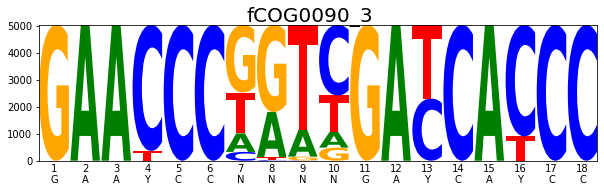

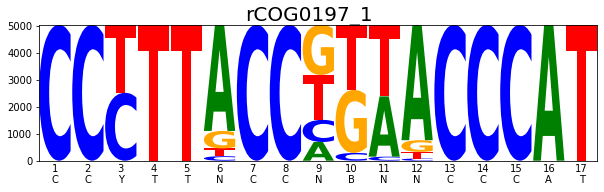

In [9]:
def get_matrix_position(seqs):
    positions = [{"A":0, 'C':0, "T":0, "G":0} for i in range(len(seqs[0]))]
    for s in seqs:
        for l, position in zip(s,positions):
            position[l] += 1
    df = pd.DataFrame(positions)
    return df

def create_logo_from_seqs(seqs, title=None):
    df = get_matrix_position(seqs)
    deg_seq = get_degenerate_consensus_seq(seqs)
    ss_logo  = logomaker.Logo(df)
    ss_logo.style_xticks( fmt='%d', anchor=0)
    ss_logo.ax.xaxis.set_ticks_position('none')
    ss_logo.ax.xaxis.set_tick_params(pad=-1)
    ss_logo.ax.set_xticklabels([f'{i+1}\n{l}' for i, l in enumerate(deg_seq)])
    if title:
        ss_logo.fig.suptitle(title, fontsize=20)
    #ss_logo.fig.title('label')
    
    

couple_dir = 'degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_9-COG0200_1'
couple_dir = 'degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_3-COG0197_1'
json_info = get_info_couple_primers(couple_dir)

fprimers_used, rprimers_used, fprimers_to_amplicons, rprimers_to_amplicons = get_primer_used(json_info['ecopcr_file'])
get_matrix_position(rprimers_used)
    #print(dict_info)
primer1 = json_info["forward_primer"]["seq"]
p1_name = json_info["forward_primer"]["primer_id"]
primer2 = json_info["reverse_primer"]["seq"]
p2_name = json_info["reverse_primer"]["primer_id"]
#df_inf = logomaker.transform_matrix(df,from_type='counts', to_type='information')
#ss_logo = logomaker.Logo(df_inf)
create_logo_from_seqs(fprimers_used, p1_name)
create_logo_from_seqs(rprimers_used, p2_name)



In [10]:
region = 'gyrB'
couple_dir = 'ecoPCR/gyrB/'
'ecoPCR/gyrB/refseqRepRef_fgyrB-rgyrB_e0.ecopcr'

json_info = get_info_couple_primers(couple_dir)

fprimers_used, rprimers_used, fprimers_to_amplicons, rprimers_to_amplicons = get_primer_used(json_info['ecopcr_file'])
#print(dict_info)
primer1 = json_info["forward_primer"]["seq"]
p1_name = json_info["forward_primer"]["primer_id"]
primer2 = json_info["reverse_primer"]["seq"]
p2_name = json_info["reverse_primer"]["primer_id"]
get_matrix_position(rprimers_used)
#df_inf = logomaker.transform_matrix(df,from_type='counts', to_type='information')
#ss_logo = logomaker.Logo(df_inf)
create_logo_from_seqs(fprimers_used, p1_name)
create_logo_from_seqs(rprimers_used, p2_name)


FileNotFoundError: [Errno 2] No such file or directory: 'ecoPCR/gyrB/refseqRepRef_fgyrB-rgyrB_l500_L8000_e0.ecopcr'

In [19]:
import plotly.figure_factory as ff
def get_amplicon_lengths(ecopcrfile):
    lengths = []
    i = 0
    with open(ecopcrfile, encoding="utf8", errors='ignore') as fl:
        for l in fl:
            if l.startswith('#'):
                continue
            i += 1
            
            splitted_l = [e.strip() for e in l.split(' | ')]
            length = int(splitted_l[19])
            lengths.append(length)
            
    return lengths

hist_data = []
group_labels = []

couple_dir = 'degeprime_results/bash_pipeline/ecoPCR/COG0097-COG0200/COG0097_9-COG0200_1'
json_info = get_info_couple_primers(couple_dir)

lengths = get_amplicon_lengths(json_info['ecopcr_file'])
hist_data.append(lengths)
group_labels.append('COG0097-COG0200')

couple_dir = 'degeprime_results/bash_pipeline/ecoPCR/COG0090-COG0197/COG0090_3-COG0197_1'
json_info = get_info_couple_primers(couple_dir)
lengths = get_amplicon_lengths(json_info['ecopcr_file'])
hist_data.append(lengths)
group_labels.append('COG0090-COG0197')


fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
fig.show()